In [1]:
!pip install opencv-python numpy matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2
import numpy as np
import math

def interested_region(img, vertices):
    mask_color_ignore = (255,) * img.shape[2] if len(img.shape) > 2 else 255
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, mask_color_ignore)
    return cv2.bitwise_and(img, mask)

def lines_drawn(img, lines, color=[255, 0, 0], thickness=6):
    global cache, first_frame
    slope_l, slope_r, lane_l, lane_r = [], [], [], []
    α = 0.2
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 - x1 == 0: continue
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0.4:
                slope_r.append(slope)
                lane_r.append(line)
            elif slope < -0.4:
                slope_l.append(slope)
                lane_l.append(line)
    if not lane_l or not lane_r:
        return img
    slope_mean_l = np.mean(slope_l)
    slope_mean_r = np.mean(slope_r)
    mean_l = np.mean(np.array(lane_l), axis=0)
    mean_r = np.mean(np.array(lane_r), axis=0)
    y_bottom = img.shape[0]
    y_top = int(y_bottom * 0.6)
    x1_l = int((y_bottom - mean_l[0][1] + slope_mean_l * mean_l[0][0]) / slope_mean_l)
    x2_l = int((y_top - mean_l[0][1] + slope_mean_l * mean_l[0][0]) / slope_mean_l)
    x1_r = int((y_bottom - mean_r[0][1] + slope_mean_r * mean_r[0][0]) / slope_mean_r)
    x2_r = int((y_top - mean_r[0][1] + slope_mean_r * mean_r[0][0]) / slope_mean_r)
    y1_l, y2_l = y_bottom, y_top
    y1_r, y2_r = y_bottom, y_top
    present_frame = np.array([x1_l, y1_l, x2_l, y2_l, x1_r, y1_r, x2_r, y2_r], dtype="float32")
    if first_frame == 1:
        next_frame = present_frame
    else:
        next_frame = (1 - α) * cache + α * present_frame
    cache[:] = next_frame
    first_frame = 0
    cv2.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]), int(next_frame[3])), color, thickness)
    cv2.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]), int(next_frame[7])), color, thickness)
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    return lines_drawn(line_img, lines)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    global first_frame
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_yellow = np.array([20, 100, 100], dtype="uint8")
    upper_yellow = np.array([30, 255, 255], dtype="uint8")
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv2.bitwise_and(gray_image, mask_yw)
    gauss_gray = cv2.GaussianBlur(mask_yw_image, (5, 5), 0)
    canny_edges = cv2.Canny(gauss_gray, 50, 150)
    imshape = image.shape
    vertices = [np.array([
        [imshape[1] / 9, imshape[0]],
        [imshape[1] / 2 - imshape[1] / 8, imshape[0] / 2 + imshape[0] / 10],
        [imshape[1] / 2 + imshape[1] / 8, imshape[0] / 2 + imshape[0] / 10],
        [imshape[1] - imshape[1] / 9, imshape[0]]
    ], dtype=np.int32)]
    roi_image = interested_region(canny_edges, vertices)
    theta = np.pi / 180
    line_image = hough_lines(roi_image, 4, theta, 30, 100, 180)
    return weighted_img(line_image, image, α=0.8, β=1.0, λ=0.0)

# Init smoothing
cache = np.zeros(8, dtype="float32")
first_frame = 1


In [3]:
input_path = "input2.mp4"
output_path = "output2.mp4"

cap = cv2.VideoCapture(input_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = process_image(frame_rgb)
    result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    out.write(result_bgr)

cap.release()
out.release()
print("✅ Done! Saved output to:", output_path)


✅ Done! Saved output to: output2.mp4


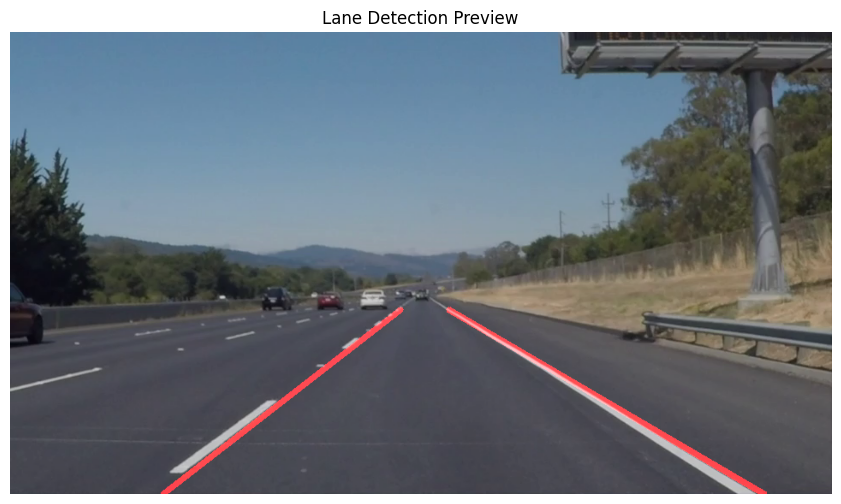

In [4]:
import matplotlib.pyplot as plt

cap = cv2.VideoCapture("input2.mp4")
ret, frame = cap.read()
cap.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
result = process_image(frame_rgb)

plt.figure(figsize=(12, 6))
plt.imshow(result)
plt.axis('off')
plt.title("Lane Detection Preview")
plt.show()


In [5]:
from IPython.display import Video

Video("output2.mp4", embed=True)
